# Model annealing
Infer a cosmological model via Continuous Tempering Langevin. 

In [ ]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.25' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Continuous Tempering Langevin")
from montecosmo.utils import pickle_dump, pickle_load, get_ylim
save_directory = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import and simulate fiducial

In [ ]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_init_mesh_fn, get_noise_fn
from montecosmo.models import default_config as config
# Build model
config.update(scale_factor_lpt=0.5, mesh_size=64*np.ones(3, dtype=int))
print(f"{config=}")
model = partial(pmrsd_model, **config)

# Get latent variables and fix cosmological parameters
cosmo_names = ['Omega_c', 'sigma8']
cosmo_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dic

# Get fiducial parameters
cond_params = {cosmo_name+'_':0. for cosmo_name in cosmo_names}
fiduc_params = get_simulator(condition(model, cond_params))(rng_seed=0)

# Condition model on observables
obs_names = ['obs_mesh']
# obs_names = ['obs_mesh','Omega_c_','sigma8_','b1_','b2_','bs_','bnl_']
obs_params = {name: fiduc_params[name] for name in obs_names}
observed_model = condition(model, obs_params)

# Get and vectorize relevant functionals
score_fn = get_score_fn(observed_model)
pk_fn = get_pk_fn(**config)
init_mesh_fn = get_init_mesh_fn(**config)
pk_vfn = vmap(vmap(pk_fn))
init_mesh_vfn = jit(vmap(vmap(init_mesh_fn)))

config={'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': False}


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


## Init diffusion

In [ ]:
from diffrax import diffeqsolve, ControlTerm, WeaklyDiagonalControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
from jax import eval_shape, debug, lax, flatten_util

def get_run_langevin(t0, t1, dt0, ts, score_fn, noise_fn, shape_struct):
    drift = lambda t, y, args: score_fn(y, model_kwargs={'noise':noise_fn(t)})
    # diffusion = lambda t, y, args: tree_map(lambda x: 2**.5 * jnp.ones_like(x), y)
    def diffusion(t, y, args):
        lax.cond(jnp.floor(10*t/t1/dt0)%jnp.floor(1/dt0), 
                 lambda:None, 
                 lambda:debug.print("t={t}, n_nan={n}", t=t, n=jnp.isnan(flatten_util.ravel_pytree(y)[0]).sum()))
        return tree_map(lambda x: 2**.5 * jnp.ones_like(x), y)
    solver = Euler()
    saveat = SaveAt(ts=ts, controller_state=True)

    @jit
    @vmap
    def run_langevin(y, seed):
        brownian_motion = VirtualBrownianTree(t0, t1, tol=jnp.abs(dt0)/10, shape=shape_struct, key=seed)
        terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
        sol = diffeqsolve(terms, solver, t0, t1, dt0=dt0, y0=y, max_steps=int(1e9), saveat=saveat)
        return sol
    
    return run_langevin

n_samples = 2
init_simulator = jit(vmap(get_simulator(condition(partial(prior_model, **config), cond_params))))
sample_key, diffeq_key = jr.split(jr.PRNGKey(43), 2)
init_params = init_simulator(jr.split(sample_key, n_samples))
# init_params = {name: init_params[name] for name in ['init_mesh_']}
init_params['init_mesh_'] = (lambda x: jnp.broadcast_to(x, (n_samples,*jnp.shape(x))))(fiduc_params['init_mesh_'])
shape_struct = eval_shape(lambda x: tree_map(lambda y:y[0], x), init_params)
t0, t1, dt0 = 0, 100, 1e-4/4
ts = jnp.linspace(t0,t1,100)
# noises = jnp.array([3,2,1,0.5,0,0])
noises = jnp.array([1,0.5,0.25,0,0])
score_vfn = jit(vmap(score_fn))

In [ ]:
from jax.flatten_util import ravel_pytree
scores = vmap(score_fn)(init_params, {'noise':jnp.ones(n_samples)})
score_flat = ravel_pytree(scores)[0]
jnp.min(score_flat)*dt0, jnp.max(score_flat)*dt0 # check if steps are not too big

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(Array(-0.3932302, dtype=float32), Array(0.17754254, dtype=float32))

## Init field power spectrum convergence

In [25]:
mlflow.end_run()
mlflow.start_run(run_name="Full inf long")
# mlflow.start_run(run_id="")
mlflow.log_params(config)
mlflow.log_params({'n_samples':n_samples,'t0':t0,'t1':t1,'dt0':dt0, 'noises':noises})

pk_init = pk_fn(fiduc_params['init_mesh'])

# Recondition model on new prior
fiduc_params2 = dict(fiduc_params)
# fiduc_params2 = dict(fiduc_params, sigma8_=-2)
pk_init2 = pk_fn(init_mesh_fn(**fiduc_params2)[1])
obs_params2 = {name: fiduc_params2[name] for name in obs_names}
score_fn2 = get_score_fn(condition(model, obs_params2))

params_ = tree_map(lambda x: jnp.broadcast_to(x, (n_samples,len(ts),*jnp.shape(x))), obs_params2)
params_.pop('obs_mesh') # won't need it
noise_fn = get_noise_fn(t0, t1, noises, steps=True)

In [26]:
mlflow.log_metric('halt',0)
run_langevin = get_run_langevin(t0, t1, dt0, ts, score_fn2, noise_fn, shape_struct)
sol = run_langevin(init_params, jr.split(diffeq_key, n_samples))
run = sol.ys
num_steps = sol.stats['num_steps']
_, meshes = init_mesh_vfn(**dict(params_, init_mesh_=run['init_mesh_']))
pks = pk_vfn(meshes)
mlflow.log_metric('halt',1), mlflow.log_metric('halt',0);

t=0.0, n_nan=0
t=0.0, n_nan=0
t=2.499999936844688e-05, n_nan=0
t=2.499999936844688e-05, n_nan=0
t=4.999999873689376e-05, n_nan=0
t=4.999999873689376e-05, n_nan=0
t=7.499999628635123e-05, n_nan=0
t=7.499999628635123e-05, n_nan=0
t=9.999999747378752e-05, n_nan=0
t=9.999999747378752e-05, n_nan=0
t=0.00012499999138526618, n_nan=0
t=0.00012499999138526618, n_nan=0
t=0.00014999999257270247, n_nan=0
t=0.00014999999257270247, n_nan=0
t=0.00017499999376013875, n_nan=0
t=0.00017499999376013875, n_nan=0
t=0.00019999999494757503, n_nan=0
t=0.00019999999494757503, n_nan=0
t=0.00022499999613501132, n_nan=0
t=0.00022499999613501132, n_nan=0
t=0.00024999998277053237, n_nan=0
t=0.00024999998277053237, n_nan=0


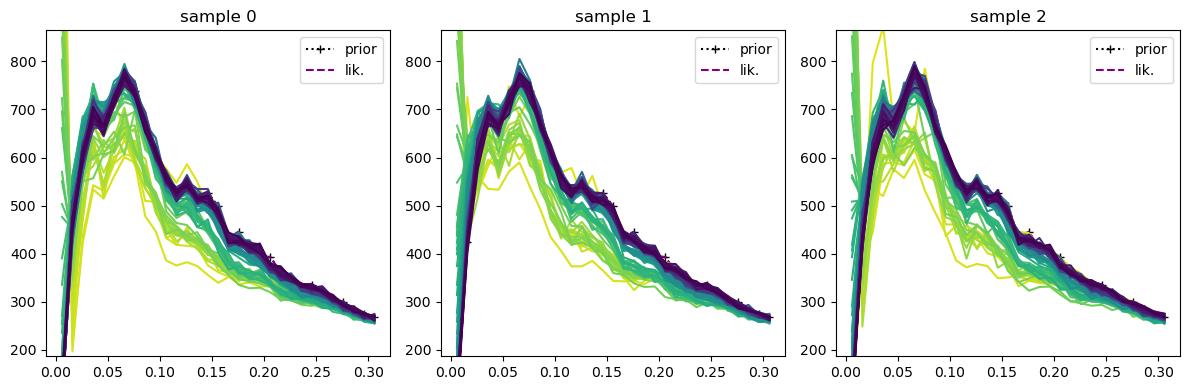

In [ ]:
# plot_pk = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[1], *args, **kwargs)
plot_pk = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)

plt.style.use('default') # default, dark_background
plt.figure(figsize=(4*n_samples,4))
for i_sample in range(n_samples):
    plt.subplot(1, n_samples, i_sample+1)
    colors = plt.get_cmap('viridis')(np.linspace(0,.95,len(ts)))[::-1]
    plt.gca().set_prop_cycle(color=colors)
    plot_pk(pk_init, '+k:', label="prior")
    plot_pk(pk_init2, '--', color='purple', label="lik.")
    plt.legend()
    for i_time, time in enumerate(ts):
        plot_pk(pks[i_sample, i_time], label=f"t={time:.1e}")
    plt.title(f"sample {i_sample}")
    plt.ylim(get_ylim(pks[...,1:].prod(-2)))
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pk00_samples.svg")
plt.show()

In [ ]:
from matplotlib import animation, rc
rc('animation', html='html5')
xx, yy = np.mgrid[[slice(0,box_l,mesh_l*1j) 
                for mesh_l,box_l in zip(config['mesh_size'][:-1],config['box_size'][:-1])]]
i_sample = 0
toplot_meshes = meshes[i_sample].reshape((-1, *config['mesh_size']))
diff_meshes = toplot_meshes - fiduc_params['init_mesh']
n_steps = num_steps[i_sample]

proj_meshes = toplot_meshes.mean(axis=-1)
residual_meshes = diff_meshes.mean(axis=-1)
# residual_meshes = (diff_meshes**2).mean(axis=(-1))**.5 / fiduc_params['init_mesh'].std()
rmses = (diff_meshes**2).mean(axis=(-1,-2,-3))**.5 / fiduc_params['init_mesh'].std()

n_lines = 10
colors = plt.get_cmap('viridis')(np.linspace(0,.95,n_lines))[::-1]
pk_traj = pks[i_sample].reshape((-1, *pk_init.shape))
noise_traj = noise_fn(ts)

plt.style.use('default') # default, dark_background
plt.figure(figsize=(lambda h:(2*h*7/6,2*h))(4)) # compensate for colorbars
plot_mesh = lambda meshes, **kwargs: plt.pcolormesh(xx, yy, meshes[0], 
                                        vmin = np.quantile(meshes, .01), 
                                        vmax = np.quantile(meshes, .99),
                                        **kwargs)
# plot_pk = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[1], *args, **kwargs)
plot_pk = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)

plt.subplot(221)
quad1 = plot_mesh(proj_meshes, cmap='viridis')
plt.xlabel("x (Mpc/h)"), plt.ylabel("y (Mpc/h)")
plt.title("samples")
plt.colorbar()

plt.subplot(222)
quad2 = plot_mesh(residual_meshes, cmap='PRGn')
plt.xlabel("x (Mpc/h)"), plt.ylabel("y (Mpc/h)")
plt.title("residuals")
plt.colorbar()

ax1 = plt.subplot(223)
line1, = plt.plot(n_steps*ts[0]/t1, rmses[0], color="b")
ax1.set_zorder(1), ax1.set_frame_on(False)
plt.xlabel("step"), plt.ylabel("RMSE/$\sigma$", color="b")
plt.xlim(0, n_steps), plt.ylim(get_ylim(rmses))
plt.twinx()
plt.ylabel("noise", color="purple")
plt.twiny(), plt.xlabel("time")
line2, = plt.plot(ts[0], noise_traj[0], color="tab:purple")
plt.xlim(t0, t1), plt.ylim(get_ylim(noise_traj))
plt.grid()

plt.subplot(224)
plt.gca().set_prop_cycle(color=colors)
plot_pk(pk_init, '+k:', label="prior")
plot_pk(pk_init2, '--', color='purple', label="lik.")
plt.legend()
lines = []
for i_line in range(n_lines):
    line, = plot_pk(pk_traj[0])
    lines.append(line)
title = plt.title(f"noise={noise_fn(0):.2f}")
plt.ylim(get_ylim(jnp.concatenate([pk_init[None], pk_init2[None], pk_traj])[...,1:].prod(-2)))
plt.grid(), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$kP(k)$ [(Mpc/h)$^2$]")
plt.tight_layout()

def update(i):
    quad1.set_array(proj_meshes[i])
    quad2.set_array(residual_meshes[i])
    line1.set_data(n_steps*ts[:i]/t1, rmses[:i])
    line2.set_data(ts[:i], noise_traj[:i])

    for i_line, line in enumerate(lines):
        i_traj = i-n_lines+1+i_line
        if i_traj < 0:
            line.set_data([],[])
        else:
            line.set_data(pk_traj[i_traj,0], pk_traj[i_traj,0]*pk_traj[i_traj,1])
        title.set_text(f"noise={noise_fn(i/len(ts)*t1):.2f}")
    return quad1, quad2, line1, line2, *lines, title

anim = animation.FuncAnimation(plt.gcf(), update, frames=len(ts), interval=100, blit=True)
plt.close()
video_name = "pk00_step_long.mp4"
anim.save(video_name)
mlflow.log_artifact(video_name)
display(anim)

NameError: name 'meshes' is not defined

## Samples analysis

In [ ]:
def plot_cosmo_contours(samples_list, samples_labels, samples_colors, cosmo_names, cosmo_labels, fiduc_cosmo_params):
    if samples_colors is None:
        samples_colors = [{'color':'b', 'alpha':0.3},{'color':'r'}]
    # Triangle plot
    samples_gds = []
    for samples in samples_list:
        samples_arr = np.array(list(samples.values())).T
        samples_gds.append(MCSamples(samples=samples_arr, names=cosmo_names, labels=cosmo_labels))
    gd = plots.get_subplot_plotter(subplot_size=None)
    # gd.settings.solid_colors='tab10_r'
    gd.triangle_plot(roots=samples_gds,
                    markers=fiduc_cosmo_params,
                    filled=True, 
                    legend_labels=samples_labels,
                    line_args=samples_colors,
                    contour_args=samples_colors,)

def plot_summary_table(samples, labels):
    # Plot summary table
    summary_dic = numpyro.diagnostics.summary(samples, group_by_chain=False) # NOTE: group_by_chain if several chains
    summary_arr = [list(list(summary_dic.values())[i].values()) for i in range(len(summary_dic.values()))]

    # Define a custom formatting function to vectorize on summary array
    def format_value(value):
        return f"{value:0.2f}"

    plt.subplot(position=[0,0,1,1]), plt.axis('off')
    # gd.fig.axes[-1]('tight'), plt.axis('tight'), plt.subplots_adjust(top=2), plt.gcf().patch.set_visible(False), 
    plt.table(cellText=np.vectorize(format_value)(summary_arr),
                # rowLabels=list(summary_dic.keys()),
                rowLabels=["$"+label+"$" for label in labels], 
                colLabels=list(list(summary_dic.values())[0].keys()),)